# Is there study bias on proteins with pathogenic mutations?
Like with the other study bias code, we perform the same analysis her, except examining each induvidual modification separately.

In [1]:
# Setup the workspace, 
from proteomeScoutAPI import ProteomeScoutAPI
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pylab import *
import pandas as pd
from scipy import stats 
import pickle

# set this to 0 if you would like to perform analysis on the entire set, 1 means we will remove extreme 
# outlier proteins in terms of lenght, GO annotations, mutations, or PTMS
FILTER = 1 
%matplotlib inline

# define input file for ProteomeScout data
proteomeScoutFile = '../../data/proteomescout_everything_20151118.tsv'

# read in ProteomeScout data
PTM_API = ProteomeScoutAPI(proteomeScoutFile)

# read in pre-processed IDs to use
humanIds = pickle.load(open('parsed_unique_IDs.p','rb'))

# read in SwissProt mutations data 
SwissProtMuts = pickle.load(open('swissprot_mutations.p','rb'))

In [2]:
print "The number of proteins being examined is: %i" % (len(humanIds))

The number of proteins being examined is: 22589


In [3]:
# for every protein get the sequence, GO terms, PTMs and mutations
protDict = {}
for ID in humanIds:
    
    # for each protein ID extract the sequence, GO terms
    # PTMs, and any mutations from the SwissProtsmMuts dataset
    tempProtDict = {}
    tempProtDict['sequence'] = PTM_API.get_sequence(ID)
    tempProtDict['GO_terms'] = PTM_API.get_GO(ID)
    
    # if we find mutations set them, else set an empty
    # list
    if ID in SwissProtMuts:
        tempProtDict['mutations'] = SwissProtMuts[ID]
    else:
        tempProtDict['mutations'] = []
    tempProtDict['PTMs'] = PTM_API.get_PTMs(ID)
    
    # having created the record add it into the protDict
    # dictionary
    protDict[ID] = tempProtDict


### Creating a PTM specific dataframe
Having extracted all the raw data, we now iterate over each protein and extract out protein-specific results, including the number of each specific type of mutation (phosphoserine, phosphothreonine, phosphotyrosine, ubiquitin, and N6-acetyllysine).

In [4]:
# create matched vectors of our items of interest
num_GO = []
num_muts = []
num_PS = []
num_PT = []
num_PY = []
num_UB = []
num_NK = []
num_PTMs = []
seqLength = []
pathoStatus = []
protIds = []

# for each ID in the protein dictionary
for ID in protDict:
    val = 0
    
    # check if any of the mutations in this protein are associated with a disease
    # according to the SwissProt disease mutation annotation
    for m in protDict[ID]['mutations']:
            if m[3] == 'Disease':            
                val = 1
    
    # set the pathogenic states
    pathoStatus.append(val)
    
    ## increment the various lists with the number of 
    # GO terms
    num_GO.append(len(protDict[ID]['GO_terms']))
    
    # Mutations
    num_muts.append(len(protDict[ID]['mutations']))
    
    # All PTMs...
    num_PTMs.append(len(protDict[ID]['PTMs']))
    
    # >>>>>>>>>>>>>
    # initialize empty list
    # tempList[0] ==> Phosphoserine
    # tempList[1] ==> Phosphothereonine
    # tempList[2] ==> Phosphotyrosine
    # tempList[3] ==> Ubiquitination 
    # tempList[4] ==> N6-acetyllysine 
    tempList = [0,0,0,0,0]
    
    # get the set of PTMs from the record
    PTMList = protDict[ID]['PTMs']
    
    # for each record incremenet the appropriate counter
    for PTM in PTMList:
        if PTM[2] == 'Phosphoserine':
            tempList[0] = tempList[0]+1
            
        if PTM[2] == 'Phosphothreonine':
            tempList[1] = tempList[1]+1
            
        if PTM[2] == 'Phosphotyrosine':
            tempList[2] = tempList[2]+1
            
        if PTM[2] == 'Ubiquitination':
            tempList[3] = tempList[3]+1
            
        if PTM[2] == 'N6-acetyllysine':
            tempList[4] = tempList[4]+1
            
            
            
    num_PS.append(tempList[0])
    num_PT.append(tempList[1])
    num_PY.append(tempList[2])
    num_UB.append(tempList[3])
    num_NK.append(tempList[4])

    
    # Sequence length
    seqLength.append(len(protDict[ID]['sequence']))
    protIds.append(ID)
    
# build a PANDAs dataframe
df = pd.DataFrame({'GO': num_GO,
                   'Mutations': num_muts,
                   'PTMs': num_PTMs,
                   'pSer': num_PS,
                   'pThr': num_PT,
                   'pTyr': num_PY,
                   'Ubiq': num_UB,
                   'N6AK': num_NK,
                   'Sequence': seqLength})

pathoS = pd.Series(pathoStatus)
protId_S = pd.Series(protIds)
df.describe()                        



,GO,Mutations,N6AK,PTMs,Sequence,Ubiq,pSer,pThr,pTyr
count,22244.000000,22244.000000,22244.000000,22244.000000,22244.000000,22244.000000,22244.000000,22244.000000,22244.000000
mean,7.903120,3.171282,0.944569,14.283672,612.651502,1.602634,5.991279,2.538392,1.721633
std,10.937723,14.429350,2.512037,23.357662,621.127045,4.070141,11.556111,4.756311,3.444046
min,0.000000,0.000000,0.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.000000,294.000000,0.000000,1.000000,0.000000,0.000000
50%,5.000000,1.000000,0.000000,8.000000,459.000000,0.000000,2.000000,1.000000,1.000000
75%,11.000000,3.000000,1.000000,17.000000,735.000000,2.000000,7.000000,3.000000,2.000000
max,159.000000,1338.000000,75.000000,1240.000000,34350.000000,205.000000,547.000000,267.000000,294.000000


We can summarize the information for each protein by printing the dataframe, as shown below;

In [5]:
df

,GO,Mutations,N6AK,PTMs,Sequence,Ubiq,pSer,pThr,pTyr
0,0,0,0,1,38,0,0,0,1
1,11,102,4,25,574,4,8,1,4
2,2,3,0,11,661,0,3,1,2
3,13,0,1,24,476,0,12,7,3
4,0,0,0,5,192,0,4,1,0
5,16,4,1,8,752,0,1,3,1
6,13,1,3,19,418,1,13,0,1
7,4,0,0,16,1114,0,15,0,1
8,0,0,0,1,484,1,0,0,0
9,14,0,1,43,1055,0,27,6,8


## Plotting 6-panel figures
Having generated a summary record for each protein, we can now go and subselect the sample of proteins which have 1 or more modification of each type, and then ask how that subsample's properties are correlated with one another. For example, in proteins with one or more phosphotyrosine modification perhaps number of pTyr sites and GO are well correlated? Who knows - let's find out!

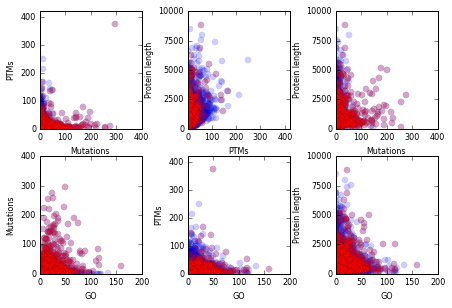

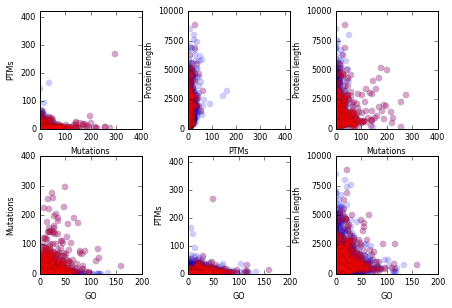

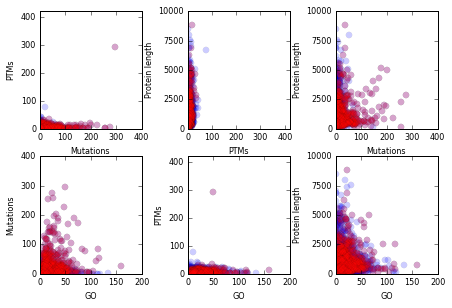

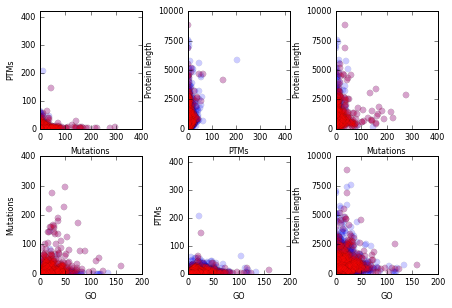

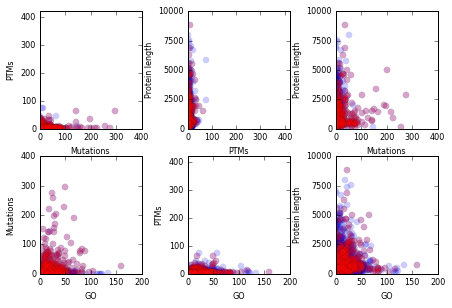

In [6]:
# set various initial parameters (can be modificed to change figure appearance)
nrows = 2
ncols = 3
SCATTER_SIZE=40
LABEL_SIZE = 8
ALPHA=0.2
BORDER_WIDTH=0.2
SHOW_LEGEND = False

# explicitly set tick labels to overide matplotlib's default spacing
TICKS = {'Mutations':np.arange(0,450,100), 'GO':np.arange(0,250,50), 'PTMs':np.arange(0,450,100),'Sequence':np.arange(0,12500,2500)}

# keep the same limits as used in the main text figure
LIMITS = {'GO':200, 'Mutations':400, 'PTMs':420,'Sequence':10000}
KEYS = ['Mutations', 'Sequence','GO']

PTM_TYPES = ['pSer', 'pThr','pTyr','Ubiq','N6AK']
KEY_PAIRS = [['Mutations','PTMs'],['PTMs','Sequence'],['Mutations','Sequence'],['GO','Mutations'],['GO','PTMs'],['GO','Sequence']]                                                        

# loop generates a 6 pannel subplot per modifictaion type
for PTM_TYPE in PTM_TYPES:
    
    # extract a subset of proteins where there is at least one modfication of the type
    # of interest
    subset = df[df[PTM_TYPE] > 1]
    
    # initialize the multiplot figure row and column indices
    idxCol = 0
    idxRow = 0

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

    for KEY_PAIR in KEY_PAIRS:

        # set keys
        key1 = KEY_PAIR[0]
        key2 = KEY_PAIR[1]
        
        # if we're looking at a PTM replace the 'PTMs' keyword with the 
        # specific PTM we're looking at!
        PTMMODE=False
        if key2 == 'PTMs':
            key2_selector = PTM_TYPE
        else:
            key2_selector = key2
            
        if key1 == 'PTMs':
            key1_selector = PTM_TYPE
        else:
            key1_selector = key1
    
                    
        # draw the scatter plot (all and pathogenic protein)    
        axes[idxRow, idxCol].scatter(subset[key1_selector], subset[key2_selector], alpha=ALPHA, lw = BORDER_WIDTH,s=SCATTER_SIZE)
        axes[idxRow, idxCol].scatter(subset[key1_selector][pathoS==1], subset[key2_selector][pathoS==1], c='r',alpha=ALPHA, lw = BORDER_WIDTH, s=SCATTER_SIZE)
        
        # set the plot object to the current axis for direct manipulation of plt variables
        plt.sca(axes[idxRow, idxCol])
    
        
        plt.xlim([0,LIMITS[key1]])
        plt.ylim([0,LIMITS[key2]])
    
        plt.xticks(TICKS[key1])
        plt.yticks(TICKS[key2])

        # change name for plots
        if key1 == 'Sequence':
            key1 = 'Protein length'
        if key2 == 'Sequence':
            key2 = 'Protein length'
    
        plt.xlabel(key1,size=LABEL_SIZE)
        plt.ylabel(key2,size=LABEL_SIZE)
        plt.tick_params(axis='x', labelsize=8)
        plt.tick_params(axis='y', labelsize=8)
        if SHOW_LEGEND:
            legend([L1,L2], LEGEND_TEXT,frameon=False,scatterpoints = 1)

        # update the row and column counter, resetting
        idxCol = idxCol + 1
        if idxCol % (ncols) == 0:
            idxCol = 0
            idxRow += 1

    savefig("figures/6_panel_figure_%s.pdf"%(PTM_TYPE),bbox_inches='tight')

In [7]:
# create plots and calculate correlation
keys = df.columns
#pathoFilt = pathoStatus[indexes]
#%print len(pathoFilt)

if FILTER:
    dfFilt = df[(np.abs(stats.zscore(df)) < 20).all(axis=1)]
    indexes = df[(np.abs(stats.zscore(df)) < 20).all(axis=1)].index.tolist()
    pathoSFilt = pathoS[indexes]
    protIdsFilt = protId_S[indexes]
    df_path = dfFilt[:][pathoSFilt==1]
    df = dfFilt
    pathoS = pathoSFilt
    protId_S = protIdsFilt
    protId_pathoS = protId_S[pathoSFilt==1]
else:
    df_path = df[:][pathoS==1]  
    protId_pathoS = protId_S[pathoS==1]



df_path.describe()
df_path.sum()

GO             37880
Mutations      36521
N6AK            3760
PTMs           46034
Sequence     1728661
Ubiq            5558
pSer           16524
pThr            7587
pTyr            6255
dtype: int64

# Correlation across all data
#### NOTE:
With dbSNP mutations data, all the p-values for correlation were very low (p < $10^{-10}$) but with the SwissProt set of mutations now a number of the p-values are larger (notable PTMs vs. sequence and PTMs vs. GO).

In [8]:
rArr = []
pArr = []
keys = df.columns
PTM_TYPES = ['pSer', 'pThr','pTyr','Ubiq','N6AK']

for PTM_TYPE in PTM_TYPES:
    
    # extract a subset of proteins where there is at least one modfication of the type
    # of interest
    subset = df[df[PTM_TYPE] > 1]
    
    # initialize the multiplot figure!
    idxCol = 0
    idxRow = 0
    
    print "------------------------------------------------------------"
    print "     Correlation analysis for PTM type %s"%PTM_TYPE
    print "------------------------------------------------------------"
    s = ''
    for i in range(0, len(keys)):
        key1 = keys[i]
        for j in range(i+1, len(keys)):
            key2 = keys[j]
            [r, p] = stats.pearsonr(subset[key1], subset[key2])
            rArr.append(r)
            pArr.append(p)
            s = "%s%s and %s have correlation \t%0.2f with pvalue of %0.E\n"%(s, key1, key2, r, p)
    print s
    print "END OF SECTION"
    print ""
        

------------------------------------------------------------
     Correlation analysis for PTM type pSer
------------------------------------------------------------
GO and Mutations have correlation 	0.22 with pvalue of 1E-151
GO and N6AK have correlation 	0.21 with pvalue of 4E-143
GO and PTMs have correlation 	0.26 with pvalue of 1E-206
GO and Sequence have correlation 	0.01 with pvalue of 1E-01
GO and Ubiq have correlation 	0.28 with pvalue of 4E-249
GO and pSer have correlation 	0.12 with pvalue of 3E-46
GO and pThr have correlation 	0.17 with pvalue of 1E-88
GO and pTyr have correlation 	0.25 with pvalue of 5E-197
Mutations and N6AK have correlation 	0.09 with pvalue of 1E-23
Mutations and PTMs have correlation 	0.14 with pvalue of 6E-60
Mutations and Sequence have correlation 	0.20 with pvalue of 4E-122
Mutations and Ubiq have correlation 	0.02 with pvalue of 2E-02
Mutations and pSer have correlation 	0.08 with pvalue of 2E-21
Mutations and pThr have correlation 	0.11 with pvalu

In [9]:
df.corr()

,GO,Mutations,N6AK,PTMs,Sequence,Ubiq,pSer,pThr,pTyr
GO,1.000000,0.232134,0.226276,0.287245,0.040853,0.277468,0.167630,0.197152,0.266299
Mutations,0.232134,1.000000,0.094509,0.154453,0.188625,0.031222,0.099984,0.124641,0.142661
N6AK,0.226276,0.094509,1.000000,0.576654,0.172102,0.464607,0.343688,0.404503,0.365758
PTMs,0.287245,0.154453,0.576654,1.000000,0.492451,0.533510,0.891806,0.852682,0.682193
Sequence,0.040853,0.188625,0.172102,0.492451,1.000000,0.121203,0.475398,0.481807,0.359639
Ubiq,0.277468,0.031222,0.464607,0.533510,0.121203,1.000000,0.263216,0.327041,0.351130
pSer,0.167630,0.099984,0.343688,0.891806,0.475398,0.263216,1.000000,0.782741,0.513603
pThr,0.197152,0.124641,0.404503,0.852682,0.481807,0.327041,0.782741,1.000000,0.520874
pTyr,0.266299,0.142661,0.365758,0.682193,0.359639,0.351130,0.513603,0.520874,1.000000


# Correlation among pathogenic proteins

In [10]:
rArr = []
pArr = []
keys = df_path.columns

PTM_TYPES = ['pSer', 'pThr','pTyr','Ubiq','N6AK']

for PTM_TYPE in PTM_TYPES:
    
    # extract a subset of proteins where there is at least one modfication of the type
    # of interest
    subset = df_path[df_path[PTM_TYPE] > 1]
    
    # initialize the multiplot figure!
    idxCol = 0
    idxRow = 0
    s = ''
    print "------------------------------------------------------------"
    print "     Correlation analysis for PTM type %s (PATHOGENIC)"%PTM_TYPE
    print "------------------------------------------------------------"
    for i in range(0, len(keys)):
        key1 = keys[i]
        for j in range(i+1, len(keys)):
            key2 = keys[j]
            [r, p] = stats.pearsonr(subset[key1], subset[key2])
            rArr.append(r)
            pArr.append(p)
            s = "%s%s and %s have correlation \t%0.2f with pvalue of %0.E\n"%(s, key1, key2, r, p)
    print s
    print "END OF SECTION"
    print ""

        


------------------------------------------------------------
     Correlation analysis for PTM type pSer (PATHOGENIC)
------------------------------------------------------------
GO and Mutations have correlation 	0.21 with pvalue of 3E-17
GO and N6AK have correlation 	0.11 with pvalue of 8E-06
GO and PTMs have correlation 	0.23 with pvalue of 8E-22
GO and Sequence have correlation 	0.05 with pvalue of 6E-02
GO and Ubiq have correlation 	0.12 with pvalue of 4E-07
GO and pSer have correlation 	0.17 with pvalue of 1E-12
GO and pThr have correlation 	0.19 with pvalue of 5E-15
GO and pTyr have correlation 	0.23 with pvalue of 9E-22
Mutations and N6AK have correlation 	0.04 with pvalue of 7E-02
Mutations and PTMs have correlation 	0.15 with pvalue of 3E-09
Mutations and Sequence have correlation 	0.23 with pvalue of 2E-21
Mutations and Ubiq have correlation 	-0.05 with pvalue of 6E-02
Mutations and pSer have correlation 	0.10 with pvalue of 3E-05
Mutations and pThr have correlation 	0.12 wi

In [11]:
# Check to see if there is enrichment in set of proteins with pathogenic mutations for 
# increased likelihood of having other annotations

N = len(df['Sequence'])
n = len(df_path['Sequence'])
keys = df.columns
numThreshold = range(0, 30, 5)
for j in numThreshold:
    print "\nThreshold for terms > %d"%(j)
    for i in range(0, len(keys)-1):
   
        K_list = df[df[keys[i]]>j]
        k_list = df_path[df_path[keys[i]]>j]
        K = len(K_list[keys[i]])
        k = len(k_list[keys[i]])
        oddsratio, pvalue = stats.fisher_exact([[k, n-k], [K, N-K]], alternative='greater')
     
        print "%s:\t\t %0.E \t(N=%d, n=%d, K=%d, k=%d)"%(keys[i][0:5], pvalue, N, n, K, k)

    


Threshold for terms > 0
GO:		 1E-246 	(N=22231, n=2300, K=15679, k=2249)
Mutat:		 0E+00 	(N=22231, n=2300, K=12051, k=2300)
N6AK:		 2E-26 	(N=22231, n=2300, K=7158, k=997)
PTMs:		 1E+00 	(N=22231, n=2300, K=22231, k=2300)
Seque:		 1E+00 	(N=22231, n=2300, K=22231, k=2300)
Ubiq:		 2E-24 	(N=22231, n=2300, K=8830, k=1167)
pSer:		 2E-21 	(N=22231, n=2300, K=17645, k=2007)
pThr:		 1E-20 	(N=22231, n=2300, K=14506, k=1717)

Threshold for terms > 5
GO:		 1E-272 	(N=22231, n=2300, K=10106, k=1903)
Mutat:		 0E+00 	(N=22231, n=2300, K=2632, k=1331)
N6AK:		 1E-19 	(N=22231, n=2300, K=821, k=185)
PTMs:		 6E-53 	(N=22231, n=2300, K=13338, k=1744)
Seque:		 1E+00 	(N=22231, n=2300, K=22231, k=2300)
Ubiq:		 6E-13 	(N=22231, n=2300, K=1875, k=302)
pSer:		 1E-13 	(N=22231, n=2300, K=6502, k=845)
pThr:		 1E-08 	(N=22231, n=2300, K=2831, k=392)

Threshold for terms > 10
GO:		 2E-185 	(N=22231, n=2300, K=5993, k=1322)
Mutat:		 0E+00 	(N=22231, n=2300, K=1187, k=840)
N6AK:		 9E-13 	(N=22231, n=2300, K=233

2273
